In [ ]:
import numpy as np
import pandas as pd
import pprint
import re
import string
from collections import defaultdict, Counter

# os dir

In [ ]:
with open('/content/doc_1.txt', 'r') as file:
    doc1 = file.read()

with open('/content/doc_2.txt','r') as file:
    doc2 = file.read()

# PREPROCESSING

In [ ]:
token_1 = doc1.lower()
token_1 = re.sub(f"[{re.escape(string.punctuation)}]", " ", token_1)
token_1 = token_1.split()

token_2 = doc2.lower()
token_2 = re.sub(f"[{re.escape(string.punctuation)}]", " ", token_2)
token_2 = token_2.split()

# INVERTED INDEX - BOOLEAN

In [ ]:
token_1 = sorted(token_1)
token_2 = sorted(token_2)

In [ ]:
terms=list(set(token_1+token_2))

inverted_index={}
for term in terms:
  inverted_index[term]=[]
  if term in token_1:
    inverted_index[term].append('doc_1')
  if term in token_2:
    inverted_index[term].append('doc_2')

pprint.pprint(inverted_index)

{'a': ['doc_1', 'doc_2'],
 'about': ['doc_2'],
 'accurate': ['doc_2'],
 'across': ['doc_2'],
 'action': ['doc_1'],
 'activity': ['doc_1'],
 'address': ['doc_1'],
 'adopting': ['doc_1'],
 'adoption': ['doc_2'],
 'ai': ['doc_2'],
 'algorithms': ['doc_2'],
 'allows': ['doc_2'],
 'already': ['doc_1'],
 'also': ['doc_1', 'doc_2'],
 'altered': ['doc_1'],
 'amounts': ['doc_2'],
 'analyzing': ['doc_2'],
 'and': ['doc_1', 'doc_2'],
 'anomalies': ['doc_2'],
 'are': ['doc_1', 'doc_2'],
 'artificial': ['doc_2'],
 'as': ['doc_1', 'doc_2'],
 'awareness': ['doc_2'],
 'balance': ['doc_1'],
 'become': ['doc_2'],
 'being': ['doc_2'],
 'benefits': ['doc_1'],
 'better': ['doc_2'],
 'biodiversity': ['doc_1'],
 'both': ['doc_1'],
 'burning': ['doc_1'],
 'but': ['doc_1', 'doc_2'],
 'by': ['doc_2'],
 'can': ['doc_2'],
 'capability': ['doc_2'],
 'capable': ['doc_2'],
 'carbon': ['doc_1'],
 'century': ['doc_1'],
 'challenges': ['doc_1', 'doc_2'],
 'change': ['doc_1', 'doc_2'],
 'clean': ['doc_1'],
 'clear': ['d

In [ ]:
freq = Counter(terms)
stop_words = set([w for w, _ in freq.most_common(10)])
for sw in stop_words:
    inverted_index.pop(sw, None)

In [ ]:
pprint.pprint(stop_words)

{'analyzing',
 'ensuring',
 'experts',
 'footprint',
 'rising',
 'scientists',
 'to',
 'use',
 'vast',
 'ways'}


In [ ]:
print(len(inverted_index))

241


In [ ]:
def boolean_retrieve(term, index, docs):
    if term not in index:
        return set()
    return set(index[term])

In [ ]:

def eval_query(tokens, index, docs):
    stack = []

    def apply_operator(op):
        if op == "NOT":
            right = stack.pop()
            stack.append(docs - right)
        else:
            right = stack.pop()
            left = stack.pop()
            if op == "AND":
                stack.append(left & right)
            elif op == "OR":
                stack.append(left | right)

    precedence = {"NOT": 3, "AND": 2, "OR": 1}
    output = []
    ops = []

    # Shunting-yard algorithm for parentheses and precedence
    for token in tokens:
        if token not in precedence and token not in ("(", ")"):
            output.append(token)
        elif token in precedence:
            while ops and ops[-1] in precedence and precedence[ops[-1]] >= precedence[token]:
                output.append(ops.pop())
            ops.append(token)
        elif token == "(":
            ops.append(token)
        elif token == ")":
            while ops and ops[-1] != "(":
                output.append(ops.pop())
            ops.pop()

    while ops:
        output.append(ops.pop())

    # Evaluate postfix expression
    for token in output:
        if token not in precedence:
            stack.append(boolean_retrieve(token.lower(), index, docs))
        else:
            apply_operator(token)

    return stack[-1] if stack else set()

def boolean_query(query, index, docs):
    tokens = query.upper().replace("(", " ( ").replace(")", " ) ").split()
    return eval_query(tokens, index, set(docs.keys()))

documents = { 'doc_1': doc1 , 'doc_2':doc2}
print("\nQuery Results:")
print("energy AND renewable ->", boolean_query("energy AND renewable", inverted_index, documents))
print("artificial OR climate ->", boolean_query("artificial OR climate", inverted_index, documents))
print("NOT energy ->", boolean_query("NOTenergy", inverted_index, documents))
print("(renewable AND artificial) OR innovation ->", boolean_query("(renewable AND artificial) OR innovation", inverted_index, documents))
print("renewable AND NOT climate ->", boolean_query("renewable AND NOT climate", inverted_index, documents))


Query Results:
energy AND renewable -> {'doc_2', 'doc_1'}
artificial OR climate -> {'doc_2', 'doc_1'}
NOT energy -> set()
(renewable AND artificial) OR innovation -> {'doc_2'}
renewable AND NOT climate -> set()


# EXERCISE 2

In [ ]:
pip install rank_bm25

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
import nltk
from nltk.util import ngrams

# Sample dataset
docs = {
    "D1": "Information requirement: query considers the user feedback as information requirement to search.",
    "D2": "Information retrieval: query depends on the model of information retrieval used.",
    "D3": "Prediction problem: Many problems in information retrieval can be viewed as prediction problems",
    "D4": "Search: A search engine is one of applications of information retrieval models."
}

new_docs = {
    "D5": "Feedback: feedback is typically used by the system to modify the query and improve prediction",
    "D6": "information retrieval: ranking in information retrieval algorithms depends on user query"
}

# Parameters
ALPHA = 0.85  # Cosine / Jaccard similarity threshold
K = 3         # Shingle size for Jaccard

# --- Helper Functions ---
def binary_distance(u, v):
    return 0 if u.strip().lower() == v.strip().lower() else 1

def jaccard_similarity(doc1, doc2, k=3):
    shingles1 = set(ngrams(doc1.lower().split(), k))
    shingles2 = set(ngrams(doc2.lower().split(), k))
    if not shingles1 or not shingles2:
        return 0.0
    return len(shingles1 & shingles2) / len(shingles1 | shingles2)

# --- TF-IDF + Cosine Similarity ---
vectorizer = TfidfVectorizer()
all_docs = list(docs.values()) + list(new_docs.values())
tfidf_matrix = vectorizer.fit_transform(all_docs)

# Split old/new
old_matrix = tfidf_matrix[:len(docs)]
new_matrix = tfidf_matrix[len(docs):]

# --- BM25 ---
tokenized_corpus = [d.lower().split() for d in docs.values()]
bm25 = BM25Okapi(tokenized_corpus)

results = []
for i, (nid, ntext) in enumerate(new_docs.items()):
    # Step A: Title match (binary distance)
    for oid, otext in docs.items():
        if binary_distance(ntext.split(':')[0], otext.split(':')[0]) == 0:
            results.append((nid, "DUPLICATE", oid, "Title Match"))
            break
    else:
        # Step B/C: Cosine Similarity
        cos_sims = cosine_similarity(new_matrix[i], old_matrix)[0]
        best_idx = cos_sims.argmax()
        best_cos = cos_sims[best_idx]

        # Step D: Jaccard Similarity
        jac_sims = [jaccard_similarity(ntext, otext, K) for otext in docs.values()]
        best_jac = max(jac_sims)
        best_jac_id = list(docs.keys())[jac_sims.index(best_jac)]

        # Step E: BM25
        bm25_scores = bm25.get_scores(ntext.lower().split())
        best_bm25 = max(bm25_scores)
        best_bm25_id = list(docs.keys())[bm25_scores.argmax()]

        # Decision (Cosine/Jaccard > α OR BM25 very high → duplicate)
        if best_cos >= ALPHA:
            results.append((nid, "DUPLICATE", list(docs.keys())[best_idx], f"Cosine={best_cos:.3f}"))
        elif best_jac >= ALPHA:
            results.append((nid, "DUPLICATE", best_jac_id, f"Jaccard={best_jac:.3f}"))
        elif best_bm25 > 3:  # arbitrary threshold for BM25
            results.append((nid, "DUPLICATE", best_bm25_id, f"BM25={best_bm25:.3f}"))
        else:
            results.append((nid, "UNIQUE", None, f"Cosine={best_cos:.3f}, Jaccard={best_jac:.3f}, BM25={best_bm25:.3f}"))

# Display results
import pandas as pd
df = pd.DataFrame(results, columns=["NewDoc", "Decision", "MatchedDoc", "Reason"])
print(df)


  NewDoc   Decision MatchedDoc                                   Reason
0     D5     UNIQUE       None  Cosine=0.281, Jaccard=0.000, BM25=1.695
1     D6  DUPLICATE         D2                              Title Match


# BIM

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 1: Documents and Query ---
docs = [
    "information requirement query considers user feedback",
    "information retrieval query depends on retrieval model",
    "prediction problem many problems in retrieval as prediction",
    "search engine one application of retrieval models",
    "feedback improves query prediction"
]
query = "feedback improves query prediction"

# --- Step 2: Build term-document frequency matrix ---
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(docs).toarray()
terms = vectorizer.get_feature_names_out()
q_vec = vectorizer.transform([query]).toarray()

N = len(docs)  # total docs
df = np.sum(X > 0, axis=0)  # number of docs each term appears in

# --- Stage 1: BIM without relevance info ---
trk = np.log((N - df) / (df + 1e-10))  # weights

# Weighting
X_weighted = X * trk
q_weighted = q_vec * trk

# Cosine similarity
similarities = cosine_similarity(q_weighted, X_weighted)[0]
ranked_indices = np.argsort(-similarities)

print("Stage 1 Ranking (no relevance info):")
for rank, idx in enumerate(ranked_indices, 1):
    print(f"Rank {rank}: D{idx+1} (score={similarities[idx]:.3f})")

# --- Stage 2: Apply BIM with relevance info on top-2 ranked docs ---
top_docs_idx = ranked_indices[:2]  # take top 2 documents
R = len(top_docs_idx)              # number of relevant docs considered

# Count rk = number of relevant docs containing term
rk = np.sum(X[top_docs_idx, :] > 0, axis=0)

# Formula: w_k = log( (rk + 0.5) / (R - rk + 0.5) ) - log( (df - rk + 0.5) / (N - df - R + rk + 0.5) )
wk = np.log((rk + 0.5) / (R - rk + 0.5)) - np.log((df - rk + 0.5) / (N - df - R + rk + 0.5))

# Reweight docs and query
X_rel_weighted = X * wk
q_rel_weighted = q_vec * wk

# Cosine similarity again
similarities_rel = cosine_similarity(q_rel_weighted, X_rel_weighted)[0]
ranked_indices_rel = np.argsort(-similarities_rel)

print("\nStage 2 Ranking (with relevance info from top-2 docs):")
for rank, idx in enumerate(ranked_indices_rel, 1):
    print(f"Rank {rank}: D{idx+1} (score={similarities_rel[idx]:.3f})")


Stage 1 Ranking (no relevance info):
Rank 1: D5 (score=1.000)
Rank 2: D1 (score=0.085)
Rank 3: D3 (score=0.066)
Rank 4: D2 (score=0.041)
Rank 5: D4 (score=0.000)

Stage 2 Ranking (with relevance info from top-2 docs):
Rank 1: D5 (score=1.000)
Rank 2: D1 (score=0.694)
Rank 3: D2 (score=0.127)
Rank 4: D3 (score=0.026)
Rank 5: D4 (score=0.000)


# VSM

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 1: Define documents and query ---
docs = [
    "information requirement query considers user feedback",
    "information retrieval query depends on retrieval model",
    "prediction problem many problems in retrieval as prediction",
    "search engine one application of retrieval models",
]

query = "feedback improves query prediction"

# --- Step 2: Construct term-document frequency matrix ---
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(docs)
terms = count_vectorizer.get_feature_names_out()

print("Term-Document Frequency Matrix:")
print(X.toarray())
print("Terms:", terms)

# --- Step 3: Represent query as vector (same vocabulary) ---
q_vector = count_vectorizer.transform([query])

print("\nQuery Vector (count representation):")
print(q_vector.toarray())

# --- Step 4: Use TF-IDF for normalization ---
tfidf_vectorizer = TfidfVectorizer()
tfidf_docs = tfidf_vectorizer.fit_transform(docs)
tfidf_query = tfidf_vectorizer.transform([query])

print("\nTF-IDF Matrix for Documents:")
print(tfidf_docs.toarray())
print("TF-IDF Query Vector:", tfidf_query.toarray())

# --- Step 5: Cosine similarity ---
cosine_scores = cosine_similarity(tfidf_query, tfidf_docs).flatten()

print("\nCosine Similarity Scores:")
for i, score in enumerate(cosine_scores, start=1):
    print(f"D{i}: {score:.4f}")

# --- Step 6: Rank the documents ---
ranked_docs = np.argsort(-cosine_scores)  # descending order
print("\nRanking of Documents:")
for rank, idx in enumerate(ranked_docs, start=1):
    print(f"Rank {rank}: D{idx+1} (score={cosine_scores[idx]:.4f})")


Term-Document Frequency Matrix:
[[0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1]
 [0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 2 0 0]
 [0 1 0 0 0 0 1 0 1 0 0 0 0 0 2 1 1 0 0 1 0 0]
 [1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0]]
Terms: ['application' 'as' 'considers' 'depends' 'engine' 'feedback' 'in'
 'information' 'many' 'model' 'models' 'of' 'on' 'one' 'prediction'
 'problem' 'problems' 'query' 'requirement' 'retrieval' 'search' 'user']

Query Vector (count representation):
[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]]

TF-IDF Matrix for Documents:
[[0.         0.         0.43671931 0.         0.         0.43671931
  0.         0.34431452 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.34431452
  0.43671931 0.         0.         0.43671931]
 [0.         0.         0.         0.41264483 0.         0.
  0.         0.32533392 0.         0.41264483 0.         0.
  0.41264483 0.         0.         0.         0.         0.32533392
  0.         0.52

# EVALUATION METRICS

Unranked Retrieval Metrics
Precision: 0.8333333333333334
Recall: 1.0
F1 Score: 0.9090909090909091 

Ranked Retrieval Metrics
Precision@3: 1.0
R-Precision: 1.0
MRR: 1.0
MAP: 1.0


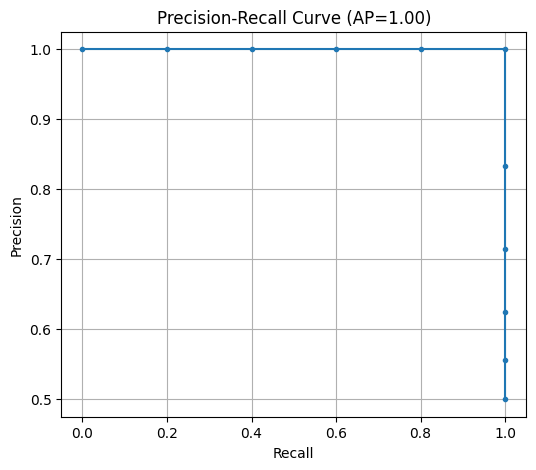


Graded Relevance Metric
nDCG@5: 0.9932683086972719


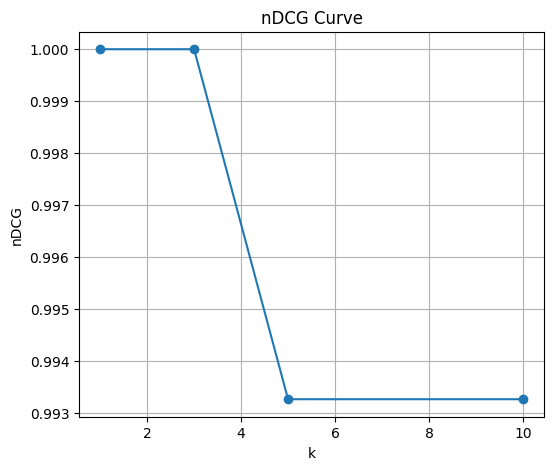

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, ndcg_score

# -----------------------------
# Example data
# -----------------------------
# Ground truth relevance (1 = relevant, 0 = not relevant)
y_true = np.array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0])

# Predicted relevance scores (from retrieval system)
y_scores = np.array([0.95, 0.6, 0.9, 0.85, 0.4, 0.3, 0.8, 0.2, 0.7, 0.1])

# Sort by predicted score (ranked retrieval)
sorted_idx = np.argsort(y_scores)[::-1]
y_true_sorted = y_true[sorted_idx]
y_scores_sorted = y_scores[sorted_idx]

# -----------------------------
# Unranked / Set-based Retrieval
# -----------------------------
y_pred_binary = (y_scores >= 0.5).astype(int)

precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print("Unranked Retrieval Metrics")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1, "\n")

# -----------------------------
# Ranked Retrieval
# -----------------------------
def precision_at_k(y_true, k):
    return np.mean(y_true[:k])

def r_precision(y_true):
    R = np.sum(y_true)  # total relevant
    return np.mean(y_true[:R])

def mean_reciprocal_rank(y_true):
    for i, val in enumerate(y_true, start=1):
        if val == 1:
            return 1.0 / i
    return 0.0

def average_precision(y_true):
    precisions = []
    rel_count = 0
    for i, val in enumerate(y_true, start=1):
        if val == 1:
            rel_count += 1
            precisions.append(rel_count / i)
    return np.mean(precisions) if precisions else 0.0

# Precision@k
print("Ranked Retrieval Metrics")
print("Precision@3:", precision_at_k(y_true_sorted, 3))
print("R-Precision:", r_precision(y_true_sorted))
print("MRR:", mean_reciprocal_rank(y_true_sorted))
print("MAP:", average_precision(y_true_sorted))

# -----------------------------
# PR Graph (built-in sklearn)
# -----------------------------
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, marker='.')
plt.title(f'Precision-Recall Curve (AP={ap:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# -----------------------------
# Graded Relevance (nDCG)
# -----------------------------
# Assume graded relevance (0 = not relevant, 3 = highly relevant)
y_true_graded = np.array([[3, 0, 2, 2, 0, 0, 1, 0, 2, 0]])
y_scores_graded = np.array([[0.95, 0.6, 0.9, 0.85, 0.4, 0.3, 0.8, 0.2, 0.7, 0.1]])

ndcg = ndcg_score(y_true_graded, y_scores_graded, k=5)
print("\nGraded Relevance Metric")
print("nDCG@5:", ndcg)

# Plot nDCG Curve
ks = [1, 3, 5, 10]
ndcgs = [ndcg_score(y_true_graded, y_scores_graded, k=k) for k in ks]

plt.figure(figsize=(6, 5))
plt.plot(ks, ndcgs, marker='o')
plt.title("nDCG Curve")
plt.xlabel("k")
plt.ylabel("nDCG")
plt.grid(True)
plt.show()
